# Import

In [1]:
import torch
from torch import nn
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR, CosineAnnealingLR
from fvcore.nn import FlopCountAnalysis, flop_count_table
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
# OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"
"""Learning rate scheduler parameters"""
NUM_EPOCHS = 180

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 150

file_path = f"MyResNet34_{BATCH}_{OPTIMIZER}"

In [3]:
file_path

'MyResNet34_128_AdamW_amsgrad'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_path)

## (4) Define Learning Rate schedualer

In [11]:
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0)

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
MyResNet34_128_AdamW_amsgrad
Current epoch is 22
Current learning rate: 0.001


In [14]:
optimizer.param_groups[0]["lr"]

0.001

In [15]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [16]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [17]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 23/180] :


23 Train:   0%|                | 0/391 [00:00<?, ?it/s]

23 Train: 100%|██████| 391/391 [00:20<00:00, 18.91it/s]

Train Loss: 0.5065 | Train Acc: 82.24%


Test  Loss: 0.6190 | Test Acc: 79.78%
--------------------------------------------------
[Epoch 24/180] :


24 Train: 100%|██████| 391/391 [00:18<00:00, 21.37it/s]


Train Loss: 0.4972 | Train Acc: 82.67%
Test  Loss: 0.4951 | Test Acc: 83.17%
updated best eval loss : 0.4950697452207155
--------------------------------------------------
[Epoch 25/180] :


25 Train: 100%|██████| 391/391 [00:17<00:00, 21.78it/s]


Train Loss: 0.4869 | Train Acc: 83.02%
Test  Loss: 0.4564 | Test Acc: 84.36%
updated best eval loss : 0.4563586029070842
--------------------------------------------------
[Epoch 26/180] :


26 Train: 100%|██████| 391/391 [00:17<00:00, 22.67it/s]


Train Loss: 0.4830 | Train Acc: 83.27%
Test  Loss: 0.5688 | Test Acc: 80.82%
--------------------------------------------------
[Epoch 27/180] :


27 Train: 100%|██████| 391/391 [00:18<00:00, 21.32it/s]


Train Loss: 0.4704 | Train Acc: 83.77%
Test  Loss: 0.5098 | Test Acc: 82.86%
--------------------------------------------------
[Epoch 28/180] :


28 Train: 100%|██████| 391/391 [00:17<00:00, 22.00it/s]


Train Loss: 0.4674 | Train Acc: 83.66%
Test  Loss: 0.5356 | Test Acc: 81.53%
--------------------------------------------------
[Epoch 29/180] :


29 Train: 100%|██████| 391/391 [00:17<00:00, 22.58it/s]


Train Loss: 0.4549 | Train Acc: 84.03%
Test  Loss: 0.5698 | Test Acc: 81.05%
--------------------------------------------------
[Epoch 30/180] :


30 Train: 100%|██████| 391/391 [00:17<00:00, 22.17it/s]


Train Loss: 0.4555 | Train Acc: 83.97%
Test  Loss: 0.5860 | Test Acc: 80.74%
--------------------------------------------------
[Epoch 31/180] :


31 Train: 100%|██████| 391/391 [00:17<00:00, 21.98it/s]


Train Loss: 0.4441 | Train Acc: 84.65%
Test  Loss: 0.5392 | Test Acc: 82.43%
--------------------------------------------------
[Epoch 32/180] :


32 Train: 100%|██████| 391/391 [00:18<00:00, 21.64it/s]


Train Loss: 0.4373 | Train Acc: 84.76%
Test  Loss: 0.5062 | Test Acc: 83.44%
--------------------------------------------------
[Epoch 33/180] :


33 Train: 100%|██████| 391/391 [00:18<00:00, 21.44it/s]


Train Loss: 0.4350 | Train Acc: 84.70%
Test  Loss: 0.4813 | Test Acc: 84.07%
--------------------------------------------------
[Epoch 34/180] :


34 Train: 100%|██████| 391/391 [00:17<00:00, 22.64it/s]


Train Loss: 0.4336 | Train Acc: 84.85%
Test  Loss: 0.4518 | Test Acc: 84.65%
updated best eval loss : 0.4517932900145084
--------------------------------------------------
[Epoch 35/180] :


35 Train: 100%|██████| 391/391 [00:17<00:00, 22.58it/s]


Train Loss: 0.4237 | Train Acc: 85.04%
Test  Loss: 0.4531 | Test Acc: 84.58%
--------------------------------------------------
[Epoch 36/180] :


36 Train: 100%|██████| 391/391 [00:18<00:00, 20.91it/s]


Train Loss: 0.4197 | Train Acc: 85.34%
Test  Loss: 0.5532 | Test Acc: 82.44%
--------------------------------------------------
[Epoch 37/180] :


37 Train: 100%|██████| 391/391 [00:17<00:00, 22.51it/s]


Train Loss: 0.4152 | Train Acc: 85.44%
Test  Loss: 0.5219 | Test Acc: 82.64%
--------------------------------------------------
[Epoch 38/180] :


38 Train: 100%|██████| 391/391 [00:17<00:00, 22.26it/s]


Train Loss: 0.4144 | Train Acc: 85.48%
Test  Loss: 0.4388 | Test Acc: 85.11%
updated best eval loss : 0.43875156361845474
--------------------------------------------------
[Epoch 39/180] :


39 Train: 100%|██████| 391/391 [00:17<00:00, 22.16it/s]


Train Loss: 0.4028 | Train Acc: 85.91%
Test  Loss: 0.5556 | Test Acc: 81.83%
--------------------------------------------------
[Epoch 40/180] :


40 Train: 100%|██████| 391/391 [00:17<00:00, 22.50it/s]


Train Loss: 0.4002 | Train Acc: 86.19%
Test  Loss: 0.4339 | Test Acc: 85.23%
updated best eval loss : 0.43390082388739043
--------------------------------------------------
[Epoch 41/180] :


41 Train: 100%|██████| 391/391 [00:17<00:00, 22.13it/s]


Train Loss: 0.3986 | Train Acc: 86.13%
Test  Loss: 0.4963 | Test Acc: 83.81%
--------------------------------------------------
[Epoch 42/180] :


42 Train: 100%|██████| 391/391 [00:17<00:00, 22.73it/s]


Train Loss: 0.3849 | Train Acc: 86.46%
Test  Loss: 0.4768 | Test Acc: 84.15%
--------------------------------------------------
[Epoch 43/180] :


43 Train: 100%|██████| 391/391 [00:18<00:00, 21.09it/s]


Train Loss: 0.3888 | Train Acc: 86.34%
Test  Loss: 0.5273 | Test Acc: 82.48%
--------------------------------------------------
[Epoch 44/180] :


44 Train: 100%|██████| 391/391 [00:18<00:00, 21.59it/s]


Train Loss: 0.3814 | Train Acc: 86.72%
Test  Loss: 0.4611 | Test Acc: 84.89%
--------------------------------------------------
[Epoch 45/180] :


45 Train: 100%|██████| 391/391 [00:17<00:00, 22.42it/s]


Train Loss: 0.3859 | Train Acc: 86.39%
Test  Loss: 0.4918 | Test Acc: 83.73%
--------------------------------------------------
[Epoch 46/180] :


46 Train: 100%|██████| 391/391 [00:17<00:00, 22.40it/s]


Train Loss: 0.3781 | Train Acc: 86.73%
Test  Loss: 0.4558 | Test Acc: 84.74%
--------------------------------------------------
[Epoch 47/180] :


47 Train: 100%|██████| 391/391 [00:17<00:00, 21.76it/s]


Train Loss: 0.3741 | Train Acc: 86.88%
Test  Loss: 0.4358 | Test Acc: 85.14%
--------------------------------------------------
[Epoch 48/180] :


48 Train: 100%|██████| 391/391 [00:17<00:00, 22.28it/s]


Train Loss: 0.3701 | Train Acc: 87.06%
Test  Loss: 0.4742 | Test Acc: 84.74%
--------------------------------------------------
[Epoch 49/180] :


49 Train: 100%|██████| 391/391 [00:18<00:00, 21.63it/s]


Train Loss: 0.3677 | Train Acc: 87.13%
Test  Loss: 0.4560 | Test Acc: 85.09%
--------------------------------------------------
[Epoch 50/180] :


50 Train: 100%|██████| 391/391 [00:17<00:00, 22.39it/s]


Train Loss: 0.3684 | Train Acc: 86.99%
Test  Loss: 0.4905 | Test Acc: 83.84%
--------------------------------------------------
[Epoch 51/180] :


51 Train: 100%|██████| 391/391 [00:18<00:00, 21.29it/s]


Train Loss: 0.3642 | Train Acc: 87.23%
Test  Loss: 0.4511 | Test Acc: 85.27%
--------------------------------------------------
[Epoch 52/180] :


52 Train: 100%|██████| 391/391 [00:17<00:00, 22.51it/s]


Train Loss: 0.3606 | Train Acc: 87.34%
Test  Loss: 0.4626 | Test Acc: 84.95%
--------------------------------------------------
[Epoch 53/180] :


53 Train: 100%|██████| 391/391 [00:17<00:00, 21.88it/s]


Train Loss: 0.3508 | Train Acc: 87.70%
Test  Loss: 0.4598 | Test Acc: 85.15%
--------------------------------------------------
[Epoch 54/180] :


54 Train: 100%|██████| 391/391 [00:18<00:00, 21.52it/s]


Train Loss: 0.3538 | Train Acc: 87.44%
Test  Loss: 0.4155 | Test Acc: 86.21%
updated best eval loss : 0.41552657417104216
--------------------------------------------------
[Epoch 55/180] :


55 Train: 100%|██████| 391/391 [00:17<00:00, 22.95it/s]


Train Loss: 0.3477 | Train Acc: 87.71%
Test  Loss: 0.4195 | Test Acc: 85.85%
--------------------------------------------------
[Epoch 56/180] :


56 Train: 100%|██████| 391/391 [00:17<00:00, 22.26it/s]


Train Loss: 0.3464 | Train Acc: 87.93%
Test  Loss: 0.4412 | Test Acc: 85.38%
--------------------------------------------------
[Epoch 57/180] :


57 Train: 100%|██████| 391/391 [00:17<00:00, 22.26it/s]


Train Loss: 0.3426 | Train Acc: 88.08%
Test  Loss: 0.4533 | Test Acc: 84.99%
--------------------------------------------------
[Epoch 58/180] :


58 Train: 100%|██████| 391/391 [00:17<00:00, 22.34it/s]


Train Loss: 0.3430 | Train Acc: 88.02%
Test  Loss: 0.4175 | Test Acc: 86.55%
--------------------------------------------------
[Epoch 59/180] :


59 Train: 100%|██████| 391/391 [00:17<00:00, 21.92it/s]


Train Loss: 0.3363 | Train Acc: 88.27%
Test  Loss: 0.4164 | Test Acc: 86.54%
--------------------------------------------------
[Epoch 60/180] :


60 Train: 100%|██████| 391/391 [00:17<00:00, 22.18it/s]


Train Loss: 0.3311 | Train Acc: 88.40%
Test  Loss: 0.3891 | Test Acc: 86.71%
updated best eval loss : 0.3891464002619061
--------------------------------------------------
[Epoch 61/180] :


61 Train: 100%|██████| 391/391 [00:17<00:00, 22.76it/s]


Train Loss: 0.3344 | Train Acc: 88.41%
Test  Loss: 0.4579 | Test Acc: 85.53%
--------------------------------------------------
[Epoch 62/180] :


62 Train: 100%|██████| 391/391 [00:17<00:00, 21.74it/s]


Train Loss: 0.3284 | Train Acc: 88.51%
Test  Loss: 0.4336 | Test Acc: 86.22%
--------------------------------------------------
[Epoch 63/180] :


63 Train: 100%|██████| 391/391 [00:17<00:00, 21.74it/s]


Train Loss: 0.3248 | Train Acc: 88.58%
Test  Loss: 0.4659 | Test Acc: 85.64%
--------------------------------------------------
[Epoch 64/180] :


64 Train: 100%|██████| 391/391 [00:18<00:00, 21.29it/s]


Train Loss: 0.3259 | Train Acc: 88.72%
Test  Loss: 0.4186 | Test Acc: 86.33%
--------------------------------------------------
[Epoch 65/180] :


65 Train: 100%|██████| 391/391 [00:17<00:00, 21.81it/s]


Train Loss: 0.3209 | Train Acc: 88.77%
Test  Loss: 0.4221 | Test Acc: 86.25%
--------------------------------------------------
[Epoch 66/180] :


66 Train: 100%|██████| 391/391 [00:17<00:00, 22.98it/s]


Train Loss: 0.3206 | Train Acc: 88.64%
Test  Loss: 0.3861 | Test Acc: 87.48%
updated best eval loss : 0.3861015259842329
--------------------------------------------------
[Epoch 67/180] :


67 Train: 100%|██████| 391/391 [00:17<00:00, 22.10it/s]


Train Loss: 0.3197 | Train Acc: 88.82%
Test  Loss: 0.4589 | Test Acc: 85.31%
--------------------------------------------------
[Epoch 68/180] :


68 Train: 100%|██████| 391/391 [00:17<00:00, 22.46it/s]


Train Loss: 0.3179 | Train Acc: 88.92%
Test  Loss: 0.5362 | Test Acc: 82.89%
--------------------------------------------------
[Epoch 69/180] :


69 Train: 100%|██████| 391/391 [00:17<00:00, 21.90it/s]


Train Loss: 0.3148 | Train Acc: 88.97%
Test  Loss: 0.4188 | Test Acc: 86.60%
--------------------------------------------------
[Epoch 70/180] :


70 Train: 100%|██████| 391/391 [00:18<00:00, 21.54it/s]


Train Loss: 0.3129 | Train Acc: 88.92%
Test  Loss: 0.4985 | Test Acc: 84.45%
--------------------------------------------------
[Epoch 71/180] :


71 Train: 100%|██████| 391/391 [00:17<00:00, 22.79it/s]


Train Loss: 0.3106 | Train Acc: 89.12%
Test  Loss: 0.4728 | Test Acc: 85.31%
--------------------------------------------------
[Epoch 72/180] :


72 Train: 100%|██████| 391/391 [00:17<00:00, 22.22it/s]


Train Loss: 0.3093 | Train Acc: 89.19%
Test  Loss: 0.4513 | Test Acc: 85.89%
--------------------------------------------------
[Epoch 73/180] :


73 Train: 100%|██████| 391/391 [00:18<00:00, 21.03it/s]


Train Loss: 0.3056 | Train Acc: 89.32%
Test  Loss: 0.5289 | Test Acc: 83.77%
--------------------------------------------------
[Epoch 74/180] :


74 Train: 100%|██████| 391/391 [00:18<00:00, 21.58it/s]


Train Loss: 0.3103 | Train Acc: 89.16%
Test  Loss: 0.4503 | Test Acc: 86.13%
--------------------------------------------------
[Epoch 75/180] :


75 Train: 100%|██████| 391/391 [00:17<00:00, 21.81it/s]


Train Loss: 0.2997 | Train Acc: 89.41%
Test  Loss: 0.4305 | Test Acc: 86.06%
--------------------------------------------------
[Epoch 76/180] :


76 Train: 100%|██████| 391/391 [00:17<00:00, 22.25it/s]


Train Loss: 0.3048 | Train Acc: 89.34%
Test  Loss: 0.4282 | Test Acc: 85.85%
--------------------------------------------------
[Epoch 77/180] :


77 Train: 100%|██████| 391/391 [00:17<00:00, 22.30it/s]


Train Loss: 0.3003 | Train Acc: 89.60%
Test  Loss: 0.4286 | Test Acc: 86.46%
--------------------------------------------------
[Epoch 78/180] :


78 Train: 100%|██████| 391/391 [00:18<00:00, 21.08it/s]


Train Loss: 0.3003 | Train Acc: 89.56%
Test  Loss: 0.4199 | Test Acc: 86.87%
--------------------------------------------------
[Epoch 79/180] :


79 Train: 100%|██████| 391/391 [00:17<00:00, 21.79it/s]


Train Loss: 0.2945 | Train Acc: 89.76%
Test  Loss: 0.4366 | Test Acc: 86.13%
--------------------------------------------------
[Epoch 80/180] :


80 Train: 100%|██████| 391/391 [00:17<00:00, 21.77it/s]


Train Loss: 0.2949 | Train Acc: 89.58%
Test  Loss: 0.4422 | Test Acc: 86.26%
--------------------------------------------------
[Epoch 81/180] :


81 Train: 100%|██████| 391/391 [00:16<00:00, 23.09it/s]


Train Loss: 0.2937 | Train Acc: 89.70%
Test  Loss: 0.4493 | Test Acc: 86.28%
--------------------------------------------------
[Epoch 82/180] :


82 Train: 100%|██████| 391/391 [00:17<00:00, 22.97it/s]


Train Loss: 0.2960 | Train Acc: 89.74%
Test  Loss: 0.4410 | Test Acc: 86.18%
--------------------------------------------------
[Epoch 83/180] :


83 Train: 100%|██████| 391/391 [00:17<00:00, 22.04it/s]


Train Loss: 0.2920 | Train Acc: 89.77%
Test  Loss: 0.4355 | Test Acc: 86.53%
--------------------------------------------------
[Epoch 84/180] :


84 Train: 100%|██████| 391/391 [00:18<00:00, 21.46it/s]


Train Loss: 0.2938 | Train Acc: 89.64%
Test  Loss: 0.4280 | Test Acc: 86.41%
--------------------------------------------------
[Epoch 85/180] :


85 Train: 100%|██████| 391/391 [00:18<00:00, 21.14it/s]


Train Loss: 0.2856 | Train Acc: 90.12%
Test  Loss: 0.3896 | Test Acc: 87.58%
--------------------------------------------------
[Epoch 86/180] :


86 Train: 100%|██████| 391/391 [00:16<00:00, 23.36it/s]


Train Loss: 0.2843 | Train Acc: 90.04%
Test  Loss: 0.4597 | Test Acc: 85.60%
--------------------------------------------------
[Epoch 87/180] :


87 Train: 100%|██████| 391/391 [00:17<00:00, 21.92it/s]


Train Loss: 0.2841 | Train Acc: 89.92%
Test  Loss: 0.3941 | Test Acc: 87.80%
--------------------------------------------------
[Epoch 88/180] :


88 Train: 100%|██████| 391/391 [00:16<00:00, 23.08it/s]


Train Loss: 0.2803 | Train Acc: 90.23%
Test  Loss: 0.4662 | Test Acc: 85.72%
--------------------------------------------------
[Epoch 89/180] :


89 Train: 100%|██████| 391/391 [00:17<00:00, 22.56it/s]


Train Loss: 0.2804 | Train Acc: 90.10%
Test  Loss: 0.4245 | Test Acc: 86.92%
--------------------------------------------------
[Epoch 90/180] :


90 Train: 100%|██████| 391/391 [00:17<00:00, 21.93it/s]


Train Loss: 0.2817 | Train Acc: 90.27%
Test  Loss: 0.3772 | Test Acc: 88.08%
updated best eval loss : 0.37720109428031534
--------------------------------------------------
[Epoch 91/180] :


91 Train: 100%|██████| 391/391 [00:17<00:00, 21.90it/s]


Train Loss: 0.2804 | Train Acc: 90.19%
Test  Loss: 0.3841 | Test Acc: 87.89%
--------------------------------------------------
[Epoch 92/180] :


92 Train: 100%|██████| 391/391 [00:18<00:00, 21.61it/s]


Train Loss: 0.2778 | Train Acc: 90.37%
Test  Loss: 0.4022 | Test Acc: 87.23%
--------------------------------------------------
[Epoch 93/180] :


93 Train: 100%|██████| 391/391 [00:17<00:00, 22.50it/s]


Train Loss: 0.2709 | Train Acc: 90.37%
Test  Loss: 0.3776 | Test Acc: 87.95%
--------------------------------------------------
[Epoch 94/180] :


94 Train: 100%|██████| 391/391 [00:19<00:00, 20.54it/s]


Train Loss: 0.2735 | Train Acc: 90.28%
Test  Loss: 0.4223 | Test Acc: 87.65%
--------------------------------------------------
[Epoch 95/180] :


95 Train: 100%|██████| 391/391 [00:17<00:00, 22.15it/s]


Train Loss: 0.2774 | Train Acc: 90.32%
Test  Loss: 0.4103 | Test Acc: 87.19%
--------------------------------------------------
[Epoch 96/180] :


96 Train: 100%|██████| 391/391 [00:17<00:00, 21.77it/s]


Train Loss: 0.2733 | Train Acc: 90.39%
Test  Loss: 0.4611 | Test Acc: 86.15%
--------------------------------------------------
[Epoch 97/180] :


97 Train: 100%|██████| 391/391 [00:17<00:00, 22.09it/s]


Train Loss: 0.2669 | Train Acc: 90.60%
Test  Loss: 0.5162 | Test Acc: 84.69%
--------------------------------------------------
[Epoch 98/180] :


98 Train: 100%|██████| 391/391 [00:17<00:00, 22.90it/s]


Train Loss: 0.2727 | Train Acc: 90.36%
Test  Loss: 0.4070 | Test Acc: 87.21%
--------------------------------------------------
[Epoch 99/180] :


99 Train: 100%|██████| 391/391 [00:17<00:00, 22.98it/s]


Train Loss: 0.2691 | Train Acc: 90.64%
Test  Loss: 0.4674 | Test Acc: 85.48%
--------------------------------------------------
[Epoch 100/180] :


100 Train: 100%|█████| 391/391 [00:17<00:00, 21.99it/s]


Train Loss: 0.2603 | Train Acc: 90.88%
Test  Loss: 0.4579 | Test Acc: 85.97%
--------------------------------------------------
[Epoch 101/180] :


101 Train: 100%|█████| 391/391 [00:18<00:00, 21.68it/s]


Train Loss: 0.2646 | Train Acc: 90.76%
Test  Loss: 0.4772 | Test Acc: 85.84%
--------------------------------------------------
[Epoch 102/180] :


102 Train: 100%|█████| 391/391 [00:18<00:00, 21.71it/s]


Train Loss: 0.2606 | Train Acc: 90.87%
Test  Loss: 0.4085 | Test Acc: 87.45%
--------------------------------------------------
[Epoch 103/180] :


103 Train: 100%|█████| 391/391 [00:16<00:00, 23.33it/s]


Train Loss: 0.2663 | Train Acc: 90.61%
Test  Loss: 0.3976 | Test Acc: 87.64%
--------------------------------------------------
[Epoch 104/180] :


104 Train: 100%|█████| 391/391 [00:17<00:00, 21.73it/s]


Train Loss: 0.2575 | Train Acc: 91.03%
Test  Loss: 0.4060 | Test Acc: 87.43%
--------------------------------------------------
[Epoch 105/180] :


105 Train: 100%|█████| 391/391 [00:17<00:00, 22.55it/s]


Train Loss: 0.2609 | Train Acc: 90.88%
Test  Loss: 0.4355 | Test Acc: 86.19%
--------------------------------------------------
[Epoch 106/180] :


106 Train: 100%|█████| 391/391 [00:18<00:00, 21.46it/s]


Train Loss: 0.2598 | Train Acc: 90.96%
Test  Loss: 0.4860 | Test Acc: 85.45%
--------------------------------------------------
[Epoch 107/180] :


107 Train: 100%|█████| 391/391 [00:17<00:00, 22.28it/s]


Train Loss: 0.2558 | Train Acc: 91.02%
Test  Loss: 0.3830 | Test Acc: 87.81%
--------------------------------------------------
[Epoch 108/180] :


108 Train: 100%|█████| 391/391 [00:17<00:00, 22.55it/s]


Train Loss: 0.2576 | Train Acc: 91.02%
Test  Loss: 0.4096 | Test Acc: 87.67%
--------------------------------------------------
[Epoch 109/180] :


109 Train: 100%|█████| 391/391 [00:17<00:00, 21.88it/s]


Train Loss: 0.2580 | Train Acc: 90.95%
Test  Loss: 0.4053 | Test Acc: 87.76%
--------------------------------------------------
[Epoch 110/180] :


110 Train: 100%|█████| 391/391 [00:17<00:00, 21.93it/s]


Train Loss: 0.2572 | Train Acc: 90.88%
Test  Loss: 0.4290 | Test Acc: 86.65%
--------------------------------------------------
[Epoch 111/180] :


111 Train: 100%|█████| 391/391 [00:17<00:00, 21.93it/s]


Train Loss: 0.2476 | Train Acc: 91.31%
Test  Loss: 0.4228 | Test Acc: 86.99%
--------------------------------------------------
[Epoch 112/180] :


112 Train: 100%|█████| 391/391 [00:17<00:00, 22.68it/s]


Train Loss: 0.2544 | Train Acc: 91.10%
Test  Loss: 0.3979 | Test Acc: 87.61%
--------------------------------------------------
[Epoch 113/180] :


113 Train: 100%|█████| 391/391 [00:17<00:00, 21.74it/s]


Train Loss: 0.2536 | Train Acc: 91.06%
Test  Loss: 0.4408 | Test Acc: 86.82%
--------------------------------------------------
[Epoch 114/180] :


114 Train: 100%|█████| 391/391 [00:17<00:00, 22.72it/s]


Train Loss: 0.2531 | Train Acc: 91.24%
Test  Loss: 0.3888 | Test Acc: 88.03%
--------------------------------------------------
[Epoch 115/180] :


115 Train: 100%|█████| 391/391 [00:18<00:00, 21.37it/s]


Train Loss: 0.2429 | Train Acc: 91.54%
Test  Loss: 0.4319 | Test Acc: 86.86%
--------------------------------------------------
[Epoch 116/180] :


116 Train: 100%|█████| 391/391 [00:18<00:00, 21.46it/s]


Train Loss: 0.2451 | Train Acc: 91.28%
Test  Loss: 0.4020 | Test Acc: 87.83%
--------------------------------------------------
[Epoch 117/180] :


117 Train: 100%|█████| 391/391 [00:18<00:00, 21.36it/s]


Train Loss: 0.2470 | Train Acc: 91.38%
Test  Loss: 0.3706 | Test Acc: 88.25%
updated best eval loss : 0.3705539138681149
--------------------------------------------------
[Epoch 118/180] :


118 Train: 100%|█████| 391/391 [00:18<00:00, 21.46it/s]


Train Loss: 0.2466 | Train Acc: 91.36%
Test  Loss: 0.4015 | Test Acc: 87.54%
--------------------------------------------------
[Epoch 119/180] :


119 Train: 100%|█████| 391/391 [00:17<00:00, 22.59it/s]


Train Loss: 0.2456 | Train Acc: 91.34%
Test  Loss: 0.4372 | Test Acc: 87.18%
--------------------------------------------------
[Epoch 120/180] :


120 Train: 100%|█████| 391/391 [00:17<00:00, 22.35it/s]


Train Loss: 0.2455 | Train Acc: 91.45%
Test  Loss: 0.4396 | Test Acc: 86.77%
--------------------------------------------------
[Epoch 121/180] :


121 Train: 100%|█████| 391/391 [00:17<00:00, 21.94it/s]


Train Loss: 0.2434 | Train Acc: 91.42%
Test  Loss: 0.3918 | Test Acc: 88.10%
--------------------------------------------------
[Epoch 122/180] :


122 Train: 100%|█████| 391/391 [00:17<00:00, 22.23it/s]


Train Loss: 0.2465 | Train Acc: 91.45%
Test  Loss: 0.4750 | Test Acc: 86.81%
--------------------------------------------------
[Epoch 123/180] :


123 Train: 100%|█████| 391/391 [00:17<00:00, 22.31it/s]


Train Loss: 0.2431 | Train Acc: 91.60%
Test  Loss: 0.4308 | Test Acc: 87.00%
--------------------------------------------------
[Epoch 124/180] :


124 Train: 100%|█████| 391/391 [00:17<00:00, 22.01it/s]


Train Loss: 0.2410 | Train Acc: 91.57%
Test  Loss: 0.3927 | Test Acc: 87.73%
--------------------------------------------------
[Epoch 125/180] :


125 Train: 100%|█████| 391/391 [00:17<00:00, 22.80it/s]


Train Loss: 0.2425 | Train Acc: 91.50%
Test  Loss: 0.4365 | Test Acc: 87.30%
--------------------------------------------------
[Epoch 126/180] :


126 Train: 100%|█████| 391/391 [00:17<00:00, 21.90it/s]


Train Loss: 0.2388 | Train Acc: 91.52%
Test  Loss: 0.3926 | Test Acc: 87.95%
--------------------------------------------------
[Epoch 127/180] :


127 Train: 100%|█████| 391/391 [00:17<00:00, 22.03it/s]


Train Loss: 0.2361 | Train Acc: 91.72%
Test  Loss: 0.4424 | Test Acc: 87.34%
--------------------------------------------------
[Epoch 128/180] :


128 Train: 100%|█████| 391/391 [00:17<00:00, 21.76it/s]


Train Loss: 0.2349 | Train Acc: 91.71%
Test  Loss: 0.4169 | Test Acc: 87.31%
--------------------------------------------------
[Epoch 129/180] :


129 Train: 100%|█████| 391/391 [00:18<00:00, 21.54it/s]


Train Loss: 0.2406 | Train Acc: 91.60%
Test  Loss: 0.3898 | Test Acc: 88.16%
--------------------------------------------------
[Epoch 130/180] :


130 Train: 100%|█████| 391/391 [00:16<00:00, 23.16it/s]


Train Loss: 0.2360 | Train Acc: 91.69%
Test  Loss: 0.4312 | Test Acc: 87.27%
--------------------------------------------------
[Epoch 131/180] :


131 Train: 100%|█████| 391/391 [00:13<00:00, 28.34it/s]


Train Loss: 0.2333 | Train Acc: 91.84%
Test  Loss: 0.4555 | Test Acc: 87.11%
--------------------------------------------------
[Epoch 132/180] :


132 Train: 100%|█████| 391/391 [00:13<00:00, 28.57it/s]


Train Loss: 0.2382 | Train Acc: 91.66%
Test  Loss: 0.4021 | Test Acc: 88.51%
--------------------------------------------------
[Epoch 133/180] :


133 Train: 100%|█████| 391/391 [00:13<00:00, 28.58it/s]


Train Loss: 0.2302 | Train Acc: 91.99%
Test  Loss: 0.4046 | Test Acc: 87.60%
--------------------------------------------------
[Epoch 134/180] :


134 Train: 100%|█████| 391/391 [00:13<00:00, 28.89it/s]


Train Loss: 0.2353 | Train Acc: 91.81%
Test  Loss: 0.4304 | Test Acc: 87.89%
--------------------------------------------------
[Epoch 135/180] :


135 Train: 100%|█████| 391/391 [00:13<00:00, 28.28it/s]


Train Loss: 0.2296 | Train Acc: 92.02%
Test  Loss: 0.4369 | Test Acc: 87.61%
--------------------------------------------------
[Epoch 136/180] :


136 Train: 100%|█████| 391/391 [00:17<00:00, 22.92it/s]


Train Loss: 0.2308 | Train Acc: 91.85%
Test  Loss: 0.4522 | Test Acc: 86.99%
--------------------------------------------------
[Epoch 137/180] :


137 Train: 100%|█████| 391/391 [00:17<00:00, 22.05it/s]


Train Loss: 0.2317 | Train Acc: 91.83%
Test  Loss: 0.4454 | Test Acc: 86.54%
--------------------------------------------------
[Epoch 138/180] :


138 Train: 100%|█████| 391/391 [00:17<00:00, 22.76it/s]


Train Loss: 0.2331 | Train Acc: 91.80%
Test  Loss: 0.4039 | Test Acc: 88.22%
--------------------------------------------------
[Epoch 139/180] :


139 Train: 100%|█████| 391/391 [00:18<00:00, 21.12it/s]


Train Loss: 0.2220 | Train Acc: 92.17%
Test  Loss: 0.4651 | Test Acc: 86.39%
--------------------------------------------------
[Epoch 140/180] :


140 Train: 100%|█████| 391/391 [00:18<00:00, 21.25it/s]


Train Loss: 0.2342 | Train Acc: 91.81%
Test  Loss: 0.4177 | Test Acc: 87.27%
--------------------------------------------------
[Epoch 141/180] :


141 Train: 100%|█████| 391/391 [00:17<00:00, 22.14it/s]


Train Loss: 0.2328 | Train Acc: 91.88%
Test  Loss: 0.4271 | Test Acc: 87.50%
--------------------------------------------------
[Epoch 142/180] :


142 Train: 100%|█████| 391/391 [00:16<00:00, 23.01it/s]


Train Loss: 0.2249 | Train Acc: 92.19%
Test  Loss: 0.4881 | Test Acc: 86.00%
--------------------------------------------------
[Epoch 143/180] :


143 Train: 100%|█████| 391/391 [00:16<00:00, 23.87it/s]


Train Loss: 0.2274 | Train Acc: 92.09%
Test  Loss: 0.4707 | Test Acc: 86.65%
--------------------------------------------------
[Epoch 144/180] :


144 Train: 100%|█████| 391/391 [00:18<00:00, 21.68it/s]


Train Loss: 0.2241 | Train Acc: 92.05%
Test  Loss: 0.3845 | Test Acc: 88.63%
--------------------------------------------------
[Epoch 145/180] :


145 Train: 100%|█████| 391/391 [00:18<00:00, 21.32it/s]


Train Loss: 0.2257 | Train Acc: 92.07%
Test  Loss: 0.4066 | Test Acc: 87.54%
--------------------------------------------------
[Epoch 146/180] :


146 Train: 100%|█████| 391/391 [00:17<00:00, 22.63it/s]


Train Loss: 0.2235 | Train Acc: 92.19%
Test  Loss: 0.3891 | Test Acc: 88.45%
--------------------------------------------------
[Epoch 147/180] :


147 Train: 100%|█████| 391/391 [00:17<00:00, 22.42it/s]


Train Loss: 0.2251 | Train Acc: 92.15%
Test  Loss: 0.4041 | Test Acc: 88.17%
--------------------------------------------------
[Epoch 148/180] :


148 Train: 100%|█████| 391/391 [00:18<00:00, 21.45it/s]


Train Loss: 0.2260 | Train Acc: 92.18%
Test  Loss: 0.4618 | Test Acc: 86.01%
--------------------------------------------------
[Epoch 149/180] :


149 Train: 100%|█████| 391/391 [00:17<00:00, 21.85it/s]


Train Loss: 0.2175 | Train Acc: 92.44%
Test  Loss: 0.4614 | Test Acc: 86.19%
--------------------------------------------------
[Epoch 150/180] :


150 Train: 100%|█████| 391/391 [00:17<00:00, 22.85it/s]


Train Loss: 0.2225 | Train Acc: 92.42%
Test  Loss: 0.5182 | Test Acc: 86.01%
--------------------------------------------------
[Epoch 151/180] :


151 Train: 100%|█████| 391/391 [00:18<00:00, 20.96it/s]


Train Loss: 0.2203 | Train Acc: 92.35%
Test  Loss: 0.3953 | Test Acc: 88.49%
--------------------------------------------------
[Epoch 152/180] :


152 Train: 100%|█████| 391/391 [00:17<00:00, 22.80it/s]


Train Loss: 0.2184 | Train Acc: 92.29%
Test  Loss: 0.4179 | Test Acc: 87.82%
--------------------------------------------------
[Epoch 153/180] :


153 Train: 100%|█████| 391/391 [00:17<00:00, 21.93it/s]


Train Loss: 0.2227 | Train Acc: 92.21%
Test  Loss: 0.4694 | Test Acc: 86.40%
--------------------------------------------------
[Epoch 154/180] :


154 Train: 100%|█████| 391/391 [00:17<00:00, 22.13it/s]


Train Loss: 0.2162 | Train Acc: 92.43%
Test  Loss: 0.4512 | Test Acc: 87.28%
--------------------------------------------------
[Epoch 155/180] :


155 Train: 100%|█████| 391/391 [00:18<00:00, 21.24it/s]


Train Loss: 0.2174 | Train Acc: 92.42%
Test  Loss: 0.4320 | Test Acc: 87.39%
--------------------------------------------------
[Epoch 156/180] :


156 Train: 100%|█████| 391/391 [00:17<00:00, 21.80it/s]


Train Loss: 0.2156 | Train Acc: 92.57%
Test  Loss: 0.4186 | Test Acc: 87.77%
--------------------------------------------------
[Epoch 157/180] :


157 Train: 100%|█████| 391/391 [00:17<00:00, 22.69it/s]


Train Loss: 0.2131 | Train Acc: 92.40%
Test  Loss: 0.4078 | Test Acc: 88.04%
--------------------------------------------------
[Epoch 158/180] :


158 Train: 100%|█████| 391/391 [00:17<00:00, 22.02it/s]


Train Loss: 0.2183 | Train Acc: 92.38%
Test  Loss: 0.4122 | Test Acc: 87.73%
--------------------------------------------------
[Epoch 159/180] :


159 Train: 100%|█████| 391/391 [00:17<00:00, 22.12it/s]


Train Loss: 0.2133 | Train Acc: 92.57%
Test  Loss: 0.3959 | Test Acc: 88.12%
--------------------------------------------------
[Epoch 160/180] :


160 Train: 100%|█████| 391/391 [00:18<00:00, 20.94it/s]


Train Loss: 0.2169 | Train Acc: 92.56%
Test  Loss: 0.4429 | Test Acc: 87.10%
--------------------------------------------------
[Epoch 161/180] :


161 Train: 100%|█████| 391/391 [00:18<00:00, 21.50it/s]


Train Loss: 0.2152 | Train Acc: 92.50%
Test  Loss: 0.3707 | Test Acc: 88.90%
--------------------------------------------------
[Epoch 162/180] :


162 Train: 100%|█████| 391/391 [00:17<00:00, 22.54it/s]


Train Loss: 0.2141 | Train Acc: 92.67%
Test  Loss: 0.4935 | Test Acc: 85.79%
--------------------------------------------------
[Epoch 163/180] :


163 Train: 100%|█████| 391/391 [00:17<00:00, 22.04it/s]


Train Loss: 0.2109 | Train Acc: 92.53%
Test  Loss: 0.4816 | Test Acc: 86.04%
--------------------------------------------------
[Epoch 164/180] :


164 Train: 100%|█████| 391/391 [00:17<00:00, 22.02it/s]


Train Loss: 0.2143 | Train Acc: 92.51%
Test  Loss: 0.3983 | Test Acc: 88.08%
--------------------------------------------------
[Epoch 165/180] :


165 Train: 100%|█████| 391/391 [00:17<00:00, 22.43it/s]


Train Loss: 0.2133 | Train Acc: 92.55%
Test  Loss: 0.4127 | Test Acc: 87.61%
--------------------------------------------------
[Epoch 166/180] :


166 Train: 100%|█████| 391/391 [00:18<00:00, 21.57it/s]


Train Loss: 0.2110 | Train Acc: 92.61%
Test  Loss: 0.3923 | Test Acc: 87.98%
--------------------------------------------------
[Epoch 167/180] :


167 Train: 100%|█████| 391/391 [00:17<00:00, 22.39it/s]


Train Loss: 0.2079 | Train Acc: 92.79%
Test  Loss: 0.4593 | Test Acc: 87.24%
--------------------------------------------------
[Epoch 168/180] :


168 Train: 100%|█████| 391/391 [00:17<00:00, 22.34it/s]


Train Loss: 0.2077 | Train Acc: 92.81%
Test  Loss: 0.4327 | Test Acc: 87.61%
--------------------------------------------------
[Epoch 169/180] :


169 Train: 100%|█████| 391/391 [00:17<00:00, 22.33it/s]


Train Loss: 0.2128 | Train Acc: 92.54%
Test  Loss: 0.3854 | Test Acc: 88.50%
--------------------------------------------------
[Epoch 170/180] :


170 Train: 100%|█████| 391/391 [00:17<00:00, 22.35it/s]


Train Loss: 0.2066 | Train Acc: 92.63%
Test  Loss: 0.4699 | Test Acc: 86.49%
--------------------------------------------------
[Epoch 171/180] :


171 Train: 100%|█████| 391/391 [00:17<00:00, 21.96it/s]


Train Loss: 0.2076 | Train Acc: 92.72%
Test  Loss: 0.4313 | Test Acc: 87.61%
--------------------------------------------------
[Epoch 172/180] :


172 Train: 100%|█████| 391/391 [00:18<00:00, 21.25it/s]


Train Loss: 0.2109 | Train Acc: 92.60%
Test  Loss: 0.3952 | Test Acc: 88.72%
--------------------------------------------------
[Epoch 173/180] :


173 Train: 100%|█████| 391/391 [00:18<00:00, 21.64it/s]


Train Loss: 0.2048 | Train Acc: 92.91%
Test  Loss: 0.3885 | Test Acc: 88.57%
--------------------------------------------------
[Epoch 174/180] :


174 Train: 100%|█████| 391/391 [00:18<00:00, 21.69it/s]


Train Loss: 0.2047 | Train Acc: 92.96%
Test  Loss: 0.3979 | Test Acc: 88.13%
--------------------------------------------------
[Epoch 175/180] :


175 Train: 100%|█████| 391/391 [00:17<00:00, 22.07it/s]


Train Loss: 0.2102 | Train Acc: 92.76%
Test  Loss: 0.4151 | Test Acc: 88.11%
--------------------------------------------------
[Epoch 176/180] :


176 Train: 100%|█████| 391/391 [00:18<00:00, 21.54it/s]


Train Loss: 0.2076 | Train Acc: 92.74%
Test  Loss: 0.4540 | Test Acc: 87.32%
--------------------------------------------------
[Epoch 177/180] :


177 Train: 100%|█████| 391/391 [00:18<00:00, 21.55it/s]


Train Loss: 0.2048 | Train Acc: 92.80%
Test  Loss: 0.4427 | Test Acc: 87.24%
--------------------------------------------------
[Epoch 178/180] :


178 Train: 100%|█████| 391/391 [00:17<00:00, 22.65it/s]


Train Loss: 0.2049 | Train Acc: 92.91%
Test  Loss: 0.4393 | Test Acc: 87.42%
--------------------------------------------------
[Epoch 179/180] :


179 Train: 100%|█████| 391/391 [00:17<00:00, 22.22it/s]


Train Loss: 0.2079 | Train Acc: 92.82%
Test  Loss: 0.4446 | Test Acc: 87.12%
--------------------------------------------------
[Epoch 180/180] :


180 Train: 100%|█████| 391/391 [00:17<00:00, 22.64it/s]


Train Loss: 0.1992 | Train Acc: 93.03%
Test  Loss: 0.4779 | Test Acc: 86.61%
--------------------------------------------------
[Epoch 181/180] :


181 Train: 100%|█████| 391/391 [00:18<00:00, 21.31it/s]


Train Loss: 0.2090 | Train Acc: 92.70%
Test  Loss: 0.4560 | Test Acc: 86.89%
--------------------------------------------------
[Epoch 182/180] :


182 Train: 100%|█████| 391/391 [00:18<00:00, 21.22it/s]


Train Loss: 0.2017 | Train Acc: 93.00%
Test  Loss: 0.4239 | Test Acc: 87.74%
--------------------------------------------------
[Epoch 183/180] :


183 Train: 100%|█████| 391/391 [00:16<00:00, 23.41it/s]


Train Loss: 0.2059 | Train Acc: 92.78%
Test  Loss: 0.3664 | Test Acc: 88.98%
updated best eval loss : 0.366433654593516
--------------------------------------------------
[Epoch 184/180] :


184 Train: 100%|█████| 391/391 [00:10<00:00, 37.56it/s]


Train Loss: 0.2043 | Train Acc: 92.86%
Test  Loss: 0.4166 | Test Acc: 88.40%
--------------------------------------------------
[Epoch 185/180] :


185 Train: 100%|█████| 391/391 [00:09<00:00, 42.84it/s]


Train Loss: 0.2028 | Train Acc: 92.96%
Test  Loss: 0.4187 | Test Acc: 87.64%
--------------------------------------------------
[Epoch 186/180] :


186 Train: 100%|█████| 391/391 [00:09<00:00, 42.58it/s]


Train Loss: 0.2027 | Train Acc: 92.93%
Test  Loss: 0.4728 | Test Acc: 86.87%
--------------------------------------------------
[Epoch 187/180] :


187 Train: 100%|█████| 391/391 [00:09<00:00, 42.42it/s]


Train Loss: 0.2062 | Train Acc: 92.78%
Test  Loss: 0.4121 | Test Acc: 88.41%
--------------------------------------------------
[Epoch 188/180] :


188 Train: 100%|█████| 391/391 [00:09<00:00, 40.85it/s]


Train Loss: 0.2023 | Train Acc: 92.97%
Test  Loss: 0.4561 | Test Acc: 86.96%
--------------------------------------------------
[Epoch 189/180] :


189 Train: 100%|█████| 391/391 [00:09<00:00, 42.05it/s]


Train Loss: 0.1997 | Train Acc: 92.96%
Test  Loss: 0.4231 | Test Acc: 87.78%
--------------------------------------------------
[Epoch 190/180] :


190 Train: 100%|█████| 391/391 [00:09<00:00, 42.06it/s]


Train Loss: 0.2006 | Train Acc: 93.11%
Test  Loss: 0.4455 | Test Acc: 87.68%
--------------------------------------------------
[Epoch 191/180] :


191 Train: 100%|█████| 391/391 [00:10<00:00, 38.79it/s]


Train Loss: 0.2006 | Train Acc: 93.07%
Test  Loss: 0.4476 | Test Acc: 87.08%
--------------------------------------------------
[Epoch 192/180] :


192 Train: 100%|█████| 391/391 [00:13<00:00, 29.70it/s]


Train Loss: 0.2000 | Train Acc: 93.07%
Test  Loss: 0.3872 | Test Acc: 88.74%
--------------------------------------------------
[Epoch 193/180] :


193 Train: 100%|█████| 391/391 [00:12<00:00, 31.15it/s]


Train Loss: 0.2025 | Train Acc: 92.99%
Test  Loss: 0.4255 | Test Acc: 88.04%
--------------------------------------------------
[Epoch 194/180] :


194 Train: 100%|█████| 391/391 [00:12<00:00, 31.42it/s]


Train Loss: 0.1968 | Train Acc: 93.11%
Test  Loss: 0.4264 | Test Acc: 87.84%
--------------------------------------------------
[Epoch 195/180] :


195 Train: 100%|█████| 391/391 [00:12<00:00, 31.03it/s]


Train Loss: 0.1973 | Train Acc: 93.01%
Test  Loss: 0.4487 | Test Acc: 87.88%
--------------------------------------------------
[Epoch 196/180] :


196 Train: 100%|█████| 391/391 [00:13<00:00, 30.05it/s]


Train Loss: 0.2006 | Train Acc: 93.05%
Test  Loss: 0.4251 | Test Acc: 87.82%
--------------------------------------------------
[Epoch 197/180] :


197 Train: 100%|█████| 391/391 [00:13<00:00, 29.84it/s]


Train Loss: 0.1982 | Train Acc: 93.14%
Test  Loss: 0.4100 | Test Acc: 88.18%
--------------------------------------------------
[Epoch 198/180] :


198 Train: 100%|█████| 391/391 [00:13<00:00, 29.97it/s]


Train Loss: 0.1970 | Train Acc: 93.23%
Test  Loss: 0.5331 | Test Acc: 86.11%
--------------------------------------------------
[Epoch 199/180] :


199 Train: 100%|█████| 391/391 [00:12<00:00, 30.52it/s]


Train Loss: 0.1954 | Train Acc: 93.17%
Test  Loss: 0.4100 | Test Acc: 88.19%
--------------------------------------------------
[Epoch 200/180] :


200 Train: 100%|█████| 391/391 [00:12<00:00, 30.89it/s]


Train Loss: 0.1973 | Train Acc: 93.08%
Test  Loss: 0.4134 | Test Acc: 88.12%
--------------------------------------------------
[Epoch 201/180] :


201 Train: 100%|█████| 391/391 [00:12<00:00, 31.23it/s]


Train Loss: 0.1925 | Train Acc: 93.41%
Test  Loss: 0.4545 | Test Acc: 87.14%
--------------------------------------------------
[Epoch 202/180] :


202 Train: 100%|█████| 391/391 [00:13<00:00, 29.91it/s]


Train Loss: 0.1927 | Train Acc: 93.24%
Test  Loss: 0.4435 | Test Acc: 87.66%
--------------------------------------------------


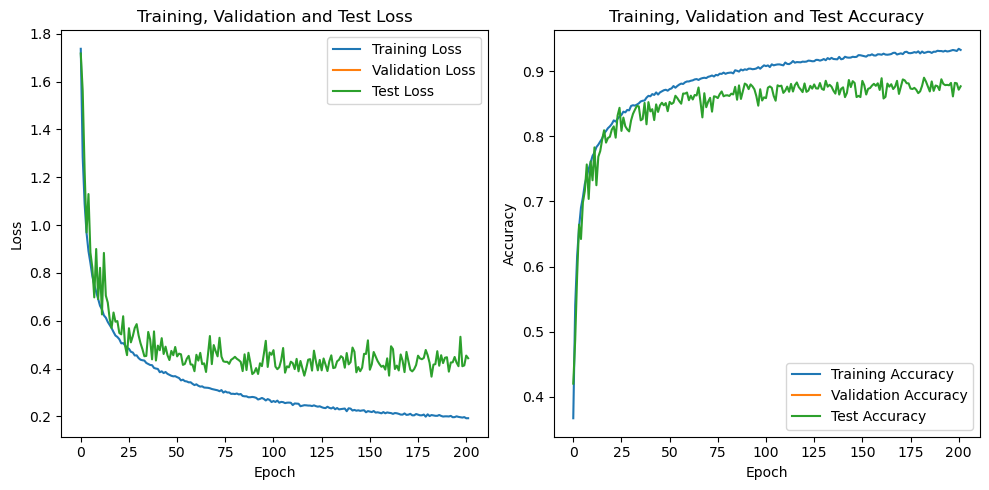

In [18]:
view = LogViewer(logs)
view.draw()

In [19]:
view.print_all()

1 epoch: train_loss=1.7368, train_acc=0.3673, test_loss=1.7171, test_acc=0.4204, lr=0.0010
2 epoch: train_loss=1.2841, train_acc=0.5406, test_loss=1.5612, test_acc=0.4875, lr=0.0010
3 epoch: train_loss=1.0886, train_acc=0.6156, test_loss=1.2267, test_acc=0.5857, lr=0.0010
4 epoch: train_loss=0.9671, train_acc=0.6603, test_loss=0.9693, test_acc=0.6644, lr=0.0010
5 epoch: train_loss=0.8912, train_acc=0.6905, test_loss=1.1296, test_acc=0.6423, lr=0.0010
6 epoch: train_loss=0.8417, train_acc=0.7064, test_loss=0.8857, test_acc=0.6984, lr=0.0010
7 epoch: train_loss=0.7866, train_acc=0.7268, test_loss=0.8221, test_acc=0.7161, lr=0.0010
8 epoch: train_loss=0.7501, train_acc=0.7384, test_loss=0.6977, test_acc=0.7567, lr=0.0010
9 epoch: train_loss=0.7210, train_acc=0.7498, test_loss=0.9000, test_acc=0.7038, lr=0.0010
10 epoch: train_loss=0.6915, train_acc=0.7595, test_loss=0.6905, test_acc=0.7614, lr=0.0010
11 epoch: train_loss=0.6626, train_acc=0.7698, test_loss=0.8214, test_acc=0.7324, lr=0.00

In [20]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))